In [ ]:
# CAM

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # 空いているGPUを指定

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

datadir='/usr/local/class/media/dataset/'

In [2]:
import torchvision.models as models

weights = models.ResNet50_Weights.DEFAULT
net = models.resnet50(weights=weights,progress=True)
softmax=nn.Softmax(dim=1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/yanai-lab/tanabe-h/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 39.5MB/s]


In [3]:
image_file='penguin.jpg'

from PIL import Image
import torchvision.transforms as transforms
image_size = (224, 224) 
normalize = weights.transforms()
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])
img_org = Image.open(image_file)
img = image_transform(img_org)
img = img.unsqueeze(0)
net.eval() 
with torch.no_grad(): 
    out=softmax(net(img)).numpy()[0]
top5   =np.sort(out)[:-6:-1]   
top5idx=np.argsort(out)[:-6:-1] 

/home/yanai-lab/tanabe-h/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
# 認識結果の top-5 の結果の表示
SYNSET_FILE='1000.txt'  # ImageNet1000 種類のカテゴリ名が書かれたファイル．
synset=open(SYNSET_FILE).read().split('\n')
for i in range(5):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5idx[i]]))

[1] 0.58740497 n02056570 king penguin, Aptenodytes patagonica
[2] 0.00290257 n04208210 shovel
[3] 0.00137841 n03891332 parking meter
[4] 0.00114948 n02071294 killer whale, killer, orca, grampus, sea wolf, Orcinus orca
[5] 0.00103077 n01817953 African grey, African gray, Psittacus erithacus


In [5]:
x = net.conv1(img)
x = net.bn1(x)
x = net.relu(x)
x = net.maxpool(x)
x = net.layer1(x)
x = net.layer2(x)
x = net.layer3(x)
x = net.layer4(x)
features = x

In [6]:
print(x.shape)
fc_weight=net.state_dict()['fc.weight']
f=fc_weight[top5idx[0]] # 認識結果第1位のカテゴリについて可視化します．#top5idx[0]を top5idx[n-1] とすれば認識結果 n番目の物体を可視化できる．
f=f.unsqueeze(1).unsqueeze(2)
print(f.shape)
cam=torch.sum(x*f,axis=1).detach().numpy() 
print(cam.shape)

torch.Size([1, 2048, 7, 7])
torch.Size([2048, 1, 1])
(1, 7, 7)


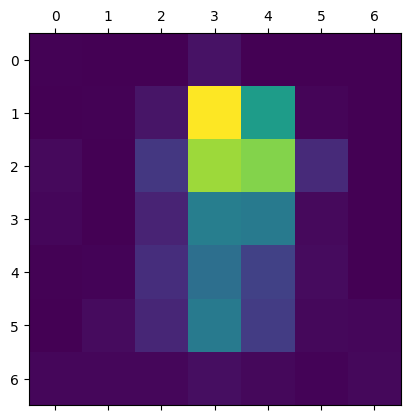

In [7]:
heatmap = np.maximum(cam[0], 0)
heatmap /= np.max(heatmap)
# print(heatmap.shape)
plt.matshow(heatmap)
plt.show()

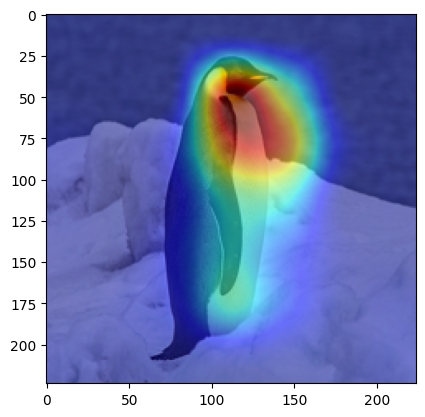

In [8]:
show_size=(224,224)

# heatmapを表示画像サイズにリサイズ．
# PILのresizeを使う．BICUBIC補間で拡大される．
heatmap = Image.fromarray(heatmap)
heatmap = heatmap.resize(show_size)
heatmap = np.array(heatmap)

# heat map に変換
def toHeatmap(x):
    x = (x*255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return x.reshape(show_size[0],show_size[1],3)

img2 = toHeatmap(heatmap)
img1 = np.array(img_org.resize(show_size),dtype=np.float64)/255.0 
alpha = 0.5
cam_image = img1*alpha + img2*(1-alpha)
plt.imshow(cam_image)

In [ ]:
# GradCAM

In [9]:
weights=models.VGG16_Weights.DEFAULT
net = models.vgg16(weights=weights,progress=True)
softmax=nn.Softmax(dim=1)
# ! ls -l ~/.cache/torch/hub/checkpoints/ 

In [10]:
image_file='penguin.jpg'

image_size = (224, 224) 
normalize = weights.transforms()
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])
img_org = Image.open(image_file)
img = image_transform(img_org)
img = img.unsqueeze(0)
net.eval() 
with torch.no_grad():
    out=softmax(net(img)).numpy()[0]
top5   =np.sort(out)[:-6:-1]   
top5idx=np.argsort(out)[:-6:-1] 
for i in range(5):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5idx[i]]))

[1] 1.00000000 n02056570 king penguin, Aptenodytes patagonica
[2] 0.00000000 n01843383 toucan
[3] 0.00000000 n02058221 albatross, mollymawk
[4] 0.00000000 n01847000 drake
[5] 0.00000000 n01855672 goose


In [11]:
x = net.features(img)
features = x
print(x.shape)

torch.Size([1, 512, 7, 7])


In [12]:
x=x.clone().detach().requires_grad_(True) # x よりも下位の層に逆伝播がいかないようにグラフを切断します．

y = net.avgpool(x)
y = net.classifier(torch.flatten(x,1,-1))

# 認識1位のクラスから誤差逆伝播を行う．
y[0][top5idx[0]].backward()  # top5idx[0]を top5idx[n-1] とすれば認識結果 n番目の物体を可視化できる．

In [13]:
print(x.grad.shape)

torch.Size([1, 512, 7, 7])


In [14]:
gap=nn.AdaptiveAvgPool2d((1,1))
grad=gap(x.grad)

In [15]:
print(x.shape)
print(grad.shape)
gcam=torch.sum(grad*x,axis=1).detach().numpy() 
print(gcam.shape)

torch.Size([1, 512, 7, 7])
torch.Size([1, 512, 1, 1])
(1, 7, 7)


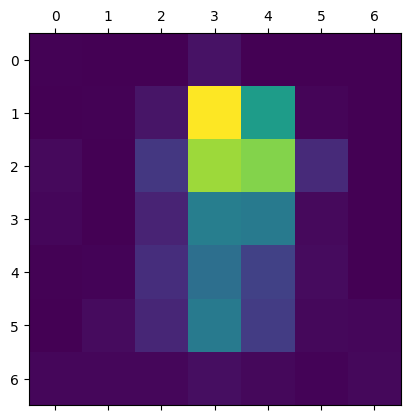

In [16]:
heatmap = np.maximum(cam[0], 0)
heatmap /= np.max(heatmap)
# print(heatmap.shape)
plt.matshow(heatmap)
plt.show()

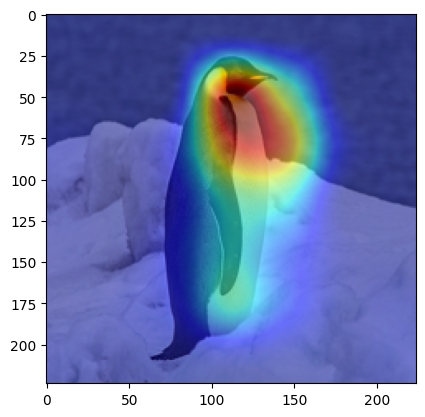

In [17]:
show_size=(224,224)

# heatmapを表示画像サイズにリサイズ．
# PILのresizeを使う．BICUBIC補間で拡大される．
heatmap = Image.fromarray(heatmap)
heatmap = heatmap.resize(show_size)
heatmap = np.array(heatmap)

# heat map に変換
def toHeatmap(x):
    x = (x*255).reshape(-1)
    cm = plt.get_cmap('jet')
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return x.reshape(show_size[0],show_size[1],3)

img2 = toHeatmap(heatmap)
img1 = np.array(img_org.resize(show_size),dtype=np.float64)/255.0 
alpha = 0.5
gcam_image = img1*alpha + img2*(1-alpha)
plt.imshow(gcam_image)